In [1]:
%matplotlib inline  
import numpy as np
import librosa.core as lr
import torchaudio
import torch
import matplotlib.pyplot as plt
import librosa.display
import librosa.feature
import magenta.music.audio_io as aio
import sounddevice as sd
from magenta.music import midi_io
from magenta.music import sequences_lib
from magenta.music import audio_io


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [178]:
sound = torchaudio.load('/Users/amir/storage/transcription/MAPS/AkPnBcht/MUS/MAPS_MUS-chpn_op66_AkPnBcht.wav', out = None)
midi = '/Users/amir/storage/transcription/MAPS/AkPnBcht/MUS/MAPS_MUS-scn15_7_AkPnBcht.mid'

In [179]:
mixer = torchaudio.transforms.DownmixMono(channels_first=True)

In [181]:
soundData = sound[0]
soundData = mixer(soundData)
soundData.shape

torch.Size([1, 12131731])

In [182]:
sound[0].shape

torch.Size([2, 12131731])

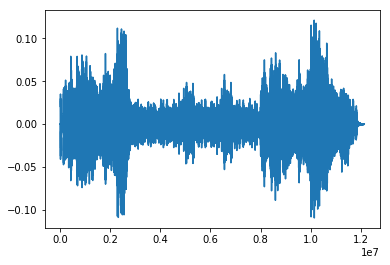

In [183]:
soundDataNumpy = soundData[0].numpy()
plt.plot(soundDataNumpy)

In [184]:
sr = sound[1]
soundDataNumpy = librosa.resample(soundDataNumpy, sr, 16000)
soundDataNumpy = soundDataNumpy.T
soundDataNumpy.shape

(4401536,)

In [189]:
from magenta.models.onsets_frames_transcription.split_audio_and_label_data import (
    find_split_points,
)
splitss= find_split_points(ns, 
                           soundDataNumpy, 
                           16000,
                           5, 
                           20)
splitss

[0.0,
 18.886103108615377,
 33.69579571398054,
 48.680462338328205,
 68.36304793237099,
 88.24187747672966,
 107.96653354655601,
 121.47865305215615,
 128.79913041535693]

In [146]:
soundDataNumpy = librosa.util.normalize(soundDataNumpy, norm=np.inf)
soundDataNumpy.shape

(7077074,)

In [147]:
def padarray(A, size):
    t = size - A.shape[0]
    return np.pad(A, (0, t), mode='constant')

In [149]:
cqt = lr.cqt(soundDataNumpy.T, sr=sr,n_bins=226, bins_per_octave=36)
C = np.abs(cqt)

In [150]:
print(C.shape)
cqtT = torch.from_numpy(C)
cqtT.shape

(226, 13823)


torch.Size([226, 13823])

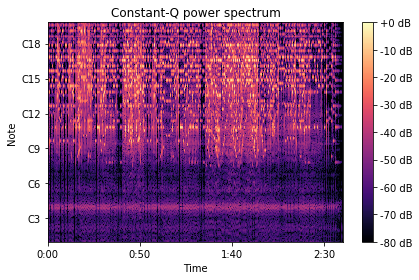

In [151]:
librosa.display.specshow(librosa.amplitude_to_db(C, ref=np.max), sr=sr, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()

In [174]:
  mel = librosa.feature.melspectrogram(
      soundDataNumpy,
      sr=sr,
      hop_length=512,
      fmin=30,
      n_mels=226,
      htk=False).astype(np.float32)
mel = mel.T
a = torch.from_numpy(mel)
a.shape

torch.Size([13823, 226])

(13823, 226)


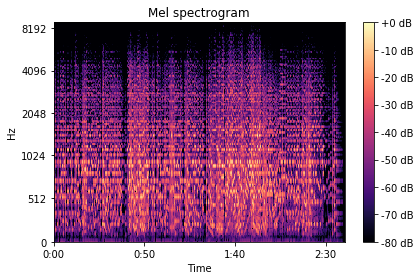

In [153]:
print(mel.T.shape)
librosa.display.specshow(librosa.power_to_db(mel, ref=np.max),
                         sr=sr,
                         fmax=9000,
                         y_axis='mel',
                         x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [125]:
recovered_song = lr.icqt(cqt, sr=sr,bins_per_octave=36)

/Users/amir/.local/share/virtualenvs/models-WVIwj_z_/lib/python3.6/site-packages/librosa/core/constantq.py:615: UserWarning: librosa.icqt is unstable, and subject to change in future versions. Please use with caution.
  warnings.warn('librosa.icqt is unstable, and subject to change in future versions. '


In [ ]:
plt.plot(recovered_song)

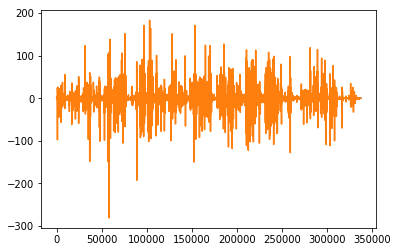

In [104]:
plt.plot(soundDataNumpy)
plt.plot(recovered_song)

In [124]:
sd.play(soundDataNumpy)
sd.stop

<function sounddevice.stop(ignore_errors=True)>

In [243]:
sd.play(recovered_song)

In [154]:
ns = midi_io.midi_file_to_note_sequence(midi)
velocities = [note.velocity for note in ns.notes]
velocity_max = np.max(velocities)
velocity_min = np.min(velocities)
new_velocity_tuple = music_pb2.VelocityRange(min=velocity_min, max=velocity_max)
type(new_velocity_tuple)
jo = MessageToJson(new_velocity_tuple)
newJo = music_pb2.VelocityRange()
Parse(jo, newJo)

min: 19
max: 63

In [155]:
type(soundDataNumpy)

numpy.ndarray

In [166]:
sr = 16000
for start, end in zip(splits[:-1], splits[1:]):
    if end - start < 5:
        continue
    print(start,end)
    new_ns = sequences_lib.extract_subsequence(ns, start, end)
    samples_to_crop = int(start * sr)
    total_samples = int((end - start) * sr)
    print(samples_to_crop, total_samples)
    cropped_samples = soundDataNumpy[samples_to_crop:(samples_to_crop + total_samples)]
cropped_samples.shape

0.0 18.886103108615377
0 302177
18.886103108615377 33.69579571398054
302177 236955
33.69579571398054 48.680462338328205
539132 239754
48.680462338328205 68.36304793237099
778887 314921
68.36304793237099 88.24187747672966
1093808 318061
88.24187747672966 107.96653354655601
1411870 315594
107.96653354655601 121.47865305215615
1727464 216193
121.47865305215615 128.79913041535693
1943658 117127


(117127,)

In [168]:
sd.play(cropped_samples)

In [53]:
from google.protobuf.json_format import MessageToJson, Parse
from magenta.protobuf import music_pb2

jsonObj = MessageToJson(ns)
newns = music_pb2.NoteSequence()
Parse(jsonObj, newns)


ticks_per_quarter: 32767
tempos {
  qpm: 136.53741125068268
}
notes {
  pitch: 60
  velocity: 51
  start_time: 2.3000091384624777
  end_time: 3.0500089114047673
}
notes {
  pitch: 65
  velocity: 58
  start_time: 3.0500089114047673
  end_time: 6.405682561113316
}
notes {
  pitch: 64
  velocity: 45
  start_time: 6.405682561113316
  end_time: 6.81384798364208
}
notes {
  pitch: 65
  velocity: 48
  start_time: 6.81384798364208
  end_time: 7.22199999511704
}
notes {
  pitch: 53
  velocity: 26
  start_time: 4.550008457289347
  end_time: 7.630165417645803
}
notes {
  pitch: 60
  velocity: 26
  start_time: 4.550008457289347
  end_time: 7.630165417645803
}
notes {
  pitch: 69
  velocity: 49
  start_time: 7.22199999511704
  end_time: 7.630165417645803
}
notes {
  pitch: 72
  velocity: 52
  start_time: 7.630165417645803
  end_time: 8.098921981261636
}
notes {
  pitch: 46
  velocity: 31
  start_time: 8.414712065187537
  end_time: 8.598912889187293
}
notes {
  pitch: 41
  velocity: 46
  start_time:

In [69]:
new_ns = sequences_lib.extract_subsequence(ns, 11, 13)
new_ns

ticks_per_quarter: 32767
tempos {
  qpm: 136.53741125068268
}
notes {
  pitch: 61
  velocity: 68
  start_time: 0.09520621112705108
  end_time: 0.2183733292641996
}
notes {
  pitch: 49
  velocity: 57
  start_time: 0.09520621112705108
  end_time: 0.2183733292641996
}
notes {
  pitch: 55
  velocity: 68
  start_time: 0.2183733292641996
  end_time: 0.3408833057649474
}
notes {
  pitch: 43
  velocity: 57
  start_time: 0.2183733292641996
  end_time: 0.3408833057649474
}
notes {
  pitch: 59
  velocity: 74
  start_time: 0.3408833057649474
  end_time: 0.4628300180059224
}
notes {
  pitch: 47
  velocity: 62
  start_time: 0.3408833057649474
  end_time: 0.4628300180059224
}
notes {
  pitch: 53
  velocity: 62
  start_time: 0.4628300180059224
  end_time: 0.5852461171300405
}
notes {
  pitch: 41
  velocity: 52
  start_time: 0.4628300180059224
  end_time: 0.5852461171300405
}
notes {
  pitch: 59
  velocity: 64
  start_time: 0.5852461171300405
  end_time: 0.7081316031373053
}
notes {
  pitch: 47
  veloc

In [54]:
newns

ticks_per_quarter: 32767
tempos {
  qpm: 136.53741125068268
}
notes {
  pitch: 60
  velocity: 51
  start_time: 2.3000091384624777
  end_time: 3.0500089114047673
}
notes {
  pitch: 65
  velocity: 58
  start_time: 3.0500089114047673
  end_time: 6.405682561113316
}
notes {
  pitch: 64
  velocity: 45
  start_time: 6.405682561113316
  end_time: 6.81384798364208
}
notes {
  pitch: 65
  velocity: 48
  start_time: 6.81384798364208
  end_time: 7.22199999511704
}
notes {
  pitch: 53
  velocity: 26
  start_time: 4.550008457289347
  end_time: 7.630165417645803
}
notes {
  pitch: 60
  velocity: 26
  start_time: 4.550008457289347
  end_time: 7.630165417645803
}
notes {
  pitch: 69
  velocity: 49
  start_time: 7.22199999511704
  end_time: 7.630165417645803
}
notes {
  pitch: 72
  velocity: 52
  start_time: 7.630165417645803
  end_time: 8.098921981261636
}
notes {
  pitch: 46
  velocity: 31
  start_time: 8.414712065187537
  end_time: 8.598912889187293
}
notes {
  pitch: 41
  velocity: 46
  start_time:

In [9]:
import os
import numpy as np
import torch
import logme

from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from tqdm import tqdm
from tensorboardX import SummaryWriter
from vusic.utils.transcription_settings import constants, training_settings
from vusic.utils.transcription_dataset import TranscriptionDataset
from vusic.transcription.modules.onset_frame_model import OnsetFrameModel
from vusic.utils.transcription_utils import summary, cycle
from vusic.transcription.modules.mel import melspectrogram
from torch.autograd import Variable
from torchviz import make_dot

In [6]:
model = OnsetFrameModel(
            constants["n_mels"],
            constants["max_midi"] - constants["min_midi"] + 1,
            48,
        )

In [14]:
dummy_input = Variable(torch.rand(1,5, 229))
y = model(dummy_input)
y

(tensor([[[0.5043, 0.5018, 0.4885, 0.5103, 0.4764, 0.5179, 0.5268, 0.5049,
           0.4869, 0.4624, 0.4925, 0.5245, 0.5154, 0.5067, 0.4776, 0.5034,
           0.4966, 0.5141, 0.5032, 0.5172, 0.5101, 0.5350, 0.5162, 0.5039,
           0.4948, 0.5139, 0.4821, 0.5035, 0.5032, 0.4828, 0.4920, 0.4712,
           0.4837, 0.4974, 0.4843, 0.4989, 0.4654, 0.4863, 0.4891, 0.4871,
           0.5039, 0.5038, 0.5143, 0.5109, 0.5091, 0.5211, 0.5136, 0.5009,
           0.5075, 0.4967, 0.5185, 0.4840, 0.4917, 0.4967, 0.5096, 0.4853,
           0.4907, 0.5098, 0.5024, 0.5202, 0.5072, 0.5071, 0.4912, 0.5057,
           0.5148, 0.4873, 0.5066, 0.5230, 0.5019, 0.5035, 0.5114, 0.5019,
           0.5441, 0.4892, 0.4886, 0.4923, 0.5080, 0.5066, 0.4884, 0.4783,
           0.4845, 0.5025, 0.5131, 0.5103, 0.4985, 0.4855, 0.4949, 0.4935],
          [0.5107, 0.4924, 0.4934, 0.5087, 0.4654, 0.5025, 0.5141, 0.5049,
           0.4928, 0.4813, 0.5050, 0.5285, 0.5199, 0.5037, 0.4631, 0.5008,
           0.5071, 0.501

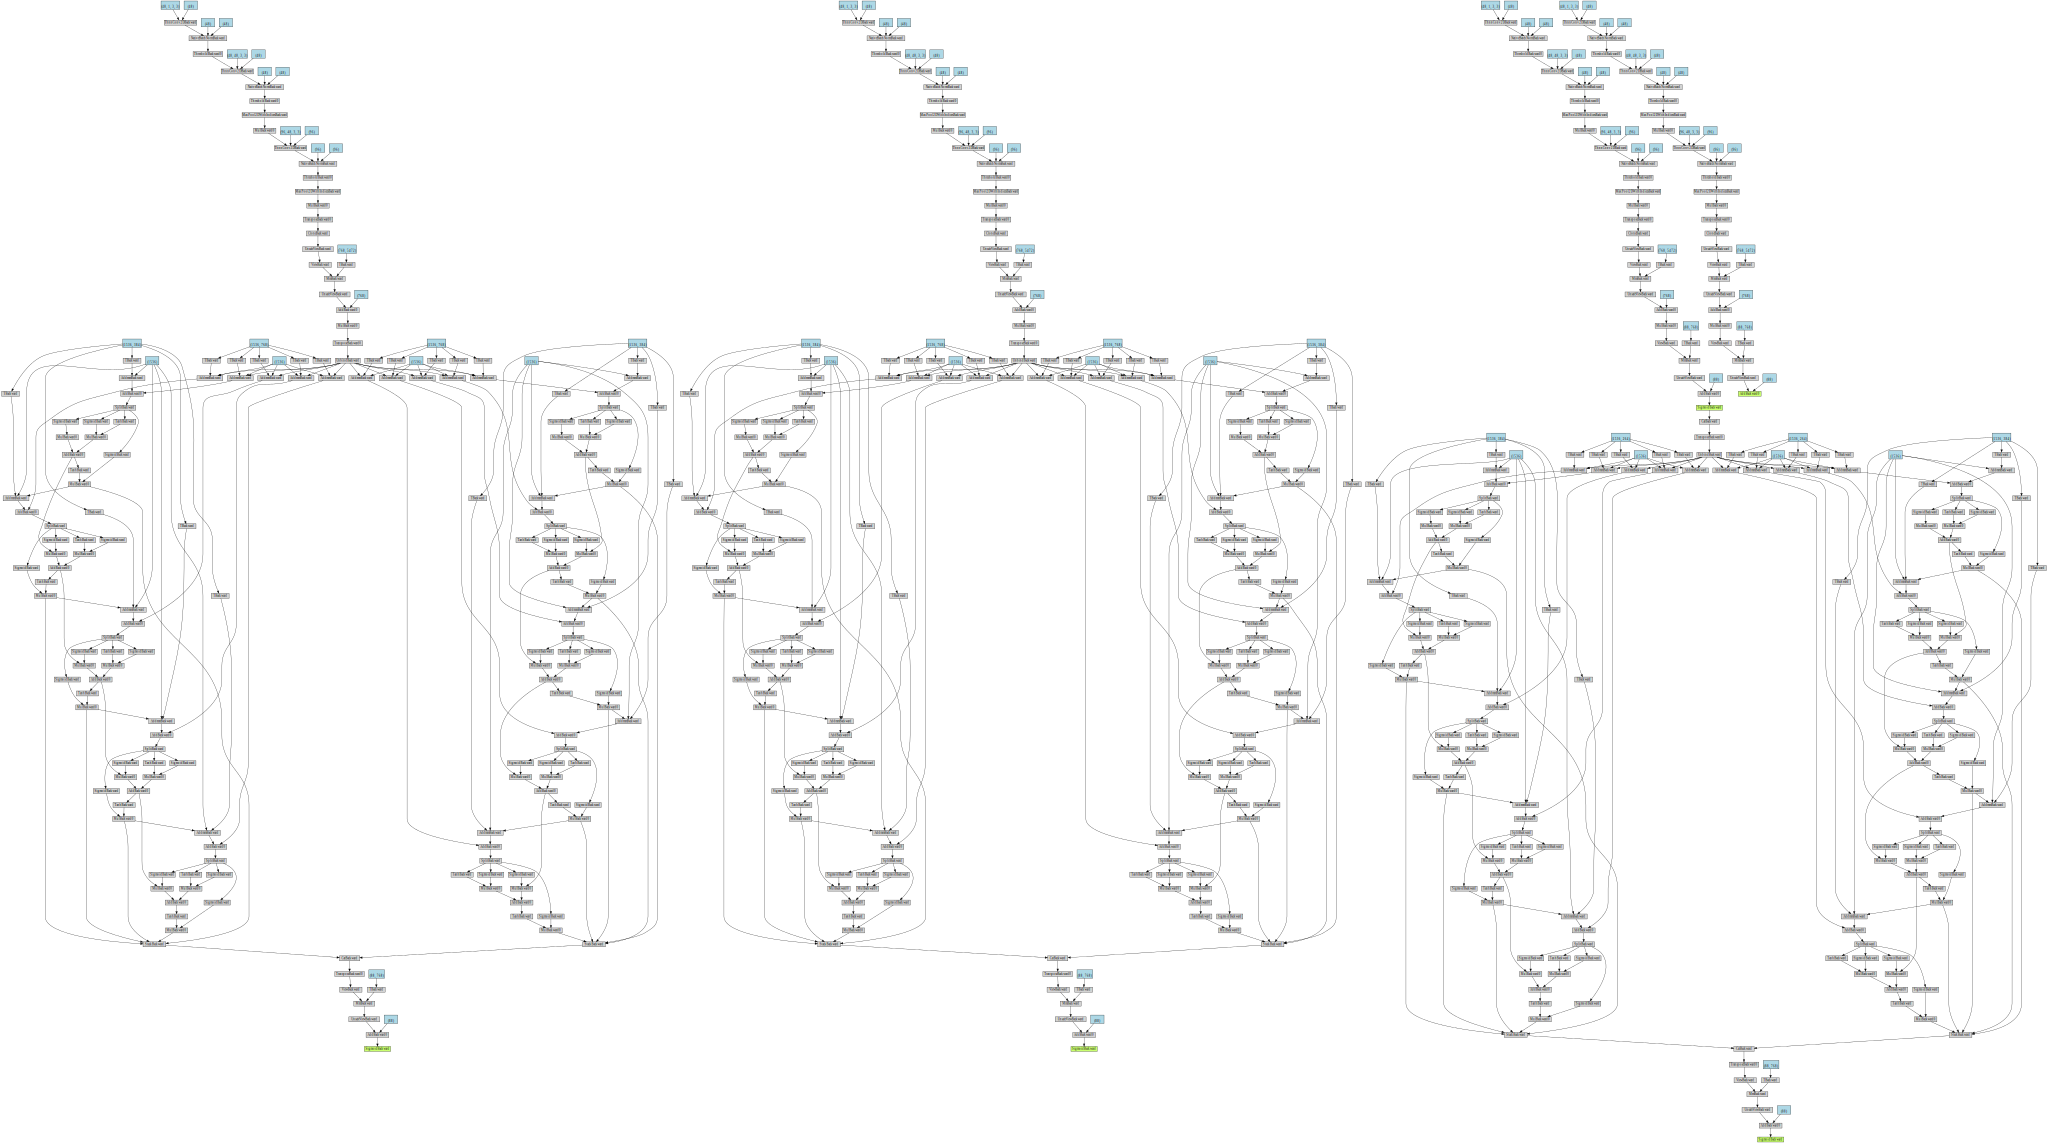

In [16]:
make_dot(y)